In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"royaldennishayford","key":"9334b7e84d53be0fcfad1ff0074bb2ba"}'}

In [2]:
import os, shutil, pathlib

home = pathlib.Path.home()
(home/".kaggle").mkdir(exist_ok=True)  # create ~/.kaggle folder if not there

# Move kaggle.json into ~/.kaggle/
shutil.move("kaggle.json", home/".kaggle/kaggle.json")

# Fix permissions so Kaggle CLI can use it
os.chmod(home/".kaggle/kaggle.json", 0o600)

print("✅ kaggle.json placed at:", home/".kaggle/kaggle.json")

✅ kaggle.json placed at: /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list -s isles

ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
orvile/isles-2022-brain-stoke-dataset                           ISLES 2022 (BRAIN STOKE DATASET)                    1706364380  2025-02-26 20:37:18.487000            334         23  0.75             
smitgandhi2005/isles-dataset                                    ISLES-Dataset                                       1292575575  2024-10-09 11:11:38.730000            102          0  0.375            
m123474/c1111hemorrhageeffnetb2abnorisles                        c1111-Hemorrhage-EffNetB2-abnor-isles               233863009  2021-09-21 04:54:29.117000              9          1  0.3125           


In [4]:
!kaggle datasets download -d orvile/isles-2022-brain-stoke-dataset -p /content/isles_data --unzip

Dataset URL: https://www.kaggle.com/datasets/orvile/isles-2022-brain-stoke-dataset
License(s): other
 99% 1.58G/1.59G [00:23<00:00, 258MB/s]
100% 1.59G/1.59G [00:23<00:00, 72.4MB/s]


In [6]:
# =========================
# CELL 1: Helper Functions & Data Discovery
# =========================

from pathlib import Path
from dataclasses import dataclass
from typing import List, Optional, Tuple, Dict
import re
import random
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset
from scipy.ndimage import zoom

def set_seed(seed: int = 42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def load_nifti(path: Path) -> Tuple[np.ndarray, np.ndarray]:
    """Load NIfTI file and return data + affine."""
    nii = nib.load(str(path))
    data = nii.get_fdata(dtype=np.float32)
    affine = nii.affine
    return data, affine

def zscore_norm(vol: np.ndarray, mask: Optional[np.ndarray] = None) -> np.ndarray:
    """Z-score normalization."""
    if mask is not None:
        region = vol[mask > 0]
    else:
        region = vol[vol > vol.min()]

    if len(region) == 0:
        return vol

    mean = region.mean()
    std = region.std()

    if std < 1e-8:
        return vol - mean

    return (vol - mean) / std

def minmax_norm(vol: np.ndarray) -> np.ndarray:
    """Min-max normalization to [0, 1]."""
    vmin, vmax = vol.min(), vol.max()
    if vmax - vmin < 1e-8:
        return vol - vmin
    return (vol - vmin) / (vmax - vmin)

def resample_iso(vol: np.ndarray, spacing: Tuple[float, float, float],
                 target_iso: float = 2.0, order: int = 1) -> np.ndarray:
    """Resample volume to isotropic spacing."""
    zoom_factors = [s / target_iso for s in spacing]
    return zoom(vol, zoom_factors, order=order)

print("✓ Helper functions loaded")

✓ Helper functions loaded


In [7]:
# =========================
# CELL 2: Data Discovery
# =========================

@dataclass
class Case:
    case_id: str
    image_path: Path
    mask_path: Path

def _is_file(p: Path) -> bool:
    """Check if path is a valid file."""
    try:
        return p.is_file() and not p.is_dir()
    except Exception:
        return False

def _find_mask_for_dwi(dwi_path: Path, all_files: List[Path]) -> Optional[Path]:
    """Find mask file corresponding to a DWI image."""
    parts = list(dwi_path.parts)

    top_sub = None
    top_ses = None

    for i, part in enumerate(parts):
        if part.startswith("sub-") and top_sub is None:
            top_sub = part
            if i + 1 < len(parts) and parts[i+1].startswith("ses-"):
                top_ses = parts[i+1]
                break

    if top_sub is None:
        return None

    for f in all_files:
        fname_lower = f.name.lower()
        if not ("msk" in fname_lower or "mask" in fname_lower or "lesion" in fname_lower):
            continue

        f_parts = list(f.parts)
        f_sub = None
        f_ses = None

        for i, part in enumerate(f_parts):
            if part.startswith("sub-") and f_sub is None:
                f_sub = part
                if i + 1 < len(f_parts) and f_parts[i+1].startswith("ses-"):
                    f_ses = f_parts[i+1]
                    break

        if f_sub == top_sub and (top_ses is None or f_ses == top_ses):
            return f

    return None

def discover_cases(root: Path, verbose: bool = True) -> List[Case]:
    """Discover DWI images and match to lesion masks."""

    if verbose:
        print(f"Searching in: {root}")

    all_files = [p for p in root.rglob("*.nii*") if _is_file(p)]

    if verbose:
        print(f"Total NIfTI files found: {len(all_files)}")

    dwi_files = []
    for p in all_files:
        fname_lower = p.name.lower()
        if "_dwi" in fname_lower or "dwi." in fname_lower or "dwi_" in fname_lower:
            if "adc" not in fname_lower and "flair" not in fname_lower:
                dwi_files.append(p)

    if verbose:
        print(f"DWI files identified: {len(dwi_files)}")

    cases = []
    for dwi in sorted(dwi_files):
        mask = _find_mask_for_dwi(dwi, all_files)
        if mask is None:
            continue

        parts = list(dwi.parts)
        sub = next((p for p in parts if p.startswith("sub-")), "unknown")
        ses = next((p for p in parts if p.startswith("ses-")), "unknown")

        case_id = f"{sub}:{ses}:{dwi.stem}"
        cases.append(Case(case_id=case_id, image_path=dwi, mask_path=mask))

    if verbose:
        print(f"Successfully matched: {len(cases)} cases")

    return cases

print("✓ Discovery functions loaded")

✓ Discovery functions loaded


In [8]:
# =========================
# CELL 3: Dataset & Splitting
# =========================

def _get_spacing(nii_path: Path) -> Tuple[float, float, float]:
    """Get voxel spacing from NIfTI header."""
    try:
        hdr = nib.load(str(nii_path)).header
        z = hdr.get_zooms()
        return tuple(float(v) for v in z[:3])
    except Exception:
        return (1.0, 1.0, 1.0)

def lesion_volume(mask: np.ndarray, spacing: Tuple[float, float, float]) -> float:
    """Calculate lesion volume in mm³."""
    voxel_volume = float(spacing[0] * spacing[1] * spacing[2])
    return float((mask > 0).sum()) * voxel_volume

def stratified_split(cases: List[Case], train: float = 0.7, val: float = 0.15,
                    seed: int = 42) -> Dict[str, List[Case]]:
    """Split cases by lesion volume quartiles."""
    set_seed(seed)

    vols = []
    valid_cases = []

    for c in cases:
        try:
            mdata = nib.load(str(c.mask_path)).get_fdata(dtype=np.float32)
            spacing = _get_spacing(c.mask_path)
            vol = lesion_volume(mdata, spacing)
            vols.append(vol)
            valid_cases.append(c)
        except Exception:
            pass

    if len(valid_cases) == 0:
        raise ValueError("No masks found for stratification.")

    cases = valid_cases
    q1, q2, q3 = np.quantile(vols, [0.25, 0.5, 0.75])

    bins = {0: [], 1: [], 2: [], 3: []}
    for i, v in enumerate(vols):
        if v <= q1:
            bins[0].append(i)
        elif v <= q2:
            bins[1].append(i)
        elif v <= q3:
            bins[2].append(i)
        else:
            bins[3].append(i)

    idx_train, idx_val, idx_test = [], [], []

    for bin_id, idxs in bins.items():
        random.shuffle(idxs)
        n = len(idxs)
        n_tr = max(1, int(n * train))
        n_val = max(0, int(n * val))

        idx_train += idxs[:n_tr]
        idx_val += idxs[n_tr:n_tr + n_val]
        idx_test += idxs[n_tr + n_val:]

    return {
        "train": [cases[i] for i in idx_train],
        "val": [cases[i] for i in idx_val],
        "test": [cases[i] for i in idx_test],
    }

@dataclass
class PreprocessConfig:
    target_iso: Optional[float] = 2.0
    norm: str = "zscore"
    use_brain_mask: bool = False

class StrokeNiftiDataset(Dataset):
    """PyTorch dataset for stroke segmentation."""

    def __init__(self, cases: List[Case], cfg: PreprocessConfig):
        self.cases = cases
        self.cfg = cfg

    def __len__(self):
        return len(self.cases)

    def __getitem__(self, idx: int):
        case = self.cases[idx]

        vol, aff = load_nifti(case.image_path)
        msk, _ = load_nifti(case.mask_path)

        spacing = _get_spacing(case.image_path)

        if self.cfg.target_iso is not None:
            vol = resample_iso(vol, spacing, target_iso=self.cfg.target_iso, order=1)
            msk = resample_iso(msk, spacing, target_iso=self.cfg.target_iso, order=0)

        brain_mask = None
        if self.cfg.use_brain_mask:
            brain_mask = (vol > np.percentile(vol, 30)).astype(np.uint8)

        if self.cfg.norm == "zscore":
            vol = zscore_norm(vol, brain_mask)
        elif self.cfg.norm == "minmax":
            vol = minmax_norm(vol)

        vol_t = torch.from_numpy(vol).float().unsqueeze(0)
        msk_t = torch.from_numpy((msk > 0).astype(np.float32)).unsqueeze(0)

        meta = {
            "case_id": case.case_id,
            "image_path": str(case.image_path),
            "mask_path": str(case.mask_path)
        }

        return {"image": vol_t, "mask": msk_t, "meta": meta}

print("✓ Dataset classes loaded")

✓ Dataset classes loaded


In [10]:
# =========================
# CELL 4: Run Data Discovery & Create Datasets (KAGGLE VERSION)
# =========================

# Kaggle dataset path
root = Path("/content/isles_data")

# If the structure is nested, you might need to adjust to:
# root = Path("/kaggle/input/isles-2022/ISLES-2022")
# or explore first to find the correct structure

# Check what's in the input directory
print("Exploring Kaggle input structure...")
if root.exists():
    print(f"Root path exists: {root}")
    subdirs = list(root.iterdir())[:5]
    print(f"First 5 items in root:")
    for item in subdirs:
        print(f"  {item.name}")
else:
    print(f"Root path does NOT exist: {root}")
    print("Available paths:")
    kaggle_input = Path("/kaggle/input")
    for item in kaggle_input.iterdir():
        print(f"  {item}")

# Discover cases
print("\nDiscovering cases...")
cases = discover_cases(root, verbose=True)

if len(cases) == 0:
    raise ValueError("No cases found! Check the path structure above.")

# Create splits
print("\nCreating splits...")
splits = stratified_split(cases, train=0.7, val=0.15, seed=42)
print(f"Train: {len(splits['train'])}, Val: {len(splits['val'])}, Test: {len(splits['test'])}")

# Create datasets
cfg = PreprocessConfig(target_iso=2.0, norm="zscore", use_brain_mask=False)
ds_train = StrokeNiftiDataset(splits["train"], cfg)
ds_val = StrokeNiftiDataset(splits["val"], cfg)
ds_test = StrokeNiftiDataset(splits["test"], cfg)

print(f"\n✓ Datasets ready!")
print(f"  Train: {len(ds_train)} samples")
print(f"  Val: {len(ds_val)} samples")
print(f"  Test: {len(ds_test)} samples")

# Test loading a sample
sample = ds_train[0]
print(f"\nSample shape: {tuple(sample['image'].shape)}")

Exploring Kaggle input structure...
Root path exists: /content/isles_data
First 5 items in root:
  ISLES-2022

Discovering cases...
Searching in: /content/isles_data
Total NIfTI files found: 1000
DWI files identified: 250
Successfully matched: 250 cases

Creating splits...
Train: 174, Val: 36, Test: 40

✓ Datasets ready!
  Train: 174 samples
  Val: 36 samples
  Test: 40 samples

Sample shape: (1, 112, 112, 73)


In [11]:
# =========================
# CELL 5: 3D U-Net Model (with Dropout)
# =========================

import torch.nn as nn
import torch.nn.functional as F

class Conv3DBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout)
        )

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=24, dropout=0.3):
        super().__init__()

        features = init_features

        self.enc1 = Conv3DBlock(in_channels, features, dropout)
        self.pool1 = nn.MaxPool3d(2, 2)

        self.enc2 = Conv3DBlock(features, features * 2, dropout)
        self.pool2 = nn.MaxPool3d(2, 2)

        self.enc3 = Conv3DBlock(features * 2, features * 4, dropout)
        self.pool3 = nn.MaxPool3d(2, 2)

        self.bottleneck = Conv3DBlock(features * 4, features * 8, dropout)

        self.upconv3 = nn.ConvTranspose3d(features * 8, features * 4, 2, stride=2)
        self.dec3 = Conv3DBlock(features * 8, features * 4, dropout)

        self.upconv2 = nn.ConvTranspose3d(features * 4, features * 2, 2, stride=2)
        self.dec2 = Conv3DBlock(features * 4, features * 2, dropout)

        self.upconv1 = nn.ConvTranspose3d(features * 2, features, 2, stride=2)
        self.dec1 = Conv3DBlock(features * 2, features, dropout)

        self.out = nn.Conv3d(features, out_channels, 1)

    def _pad_to_match(self, x, target):
        diff_d = target.size(2) - x.size(2)
        diff_h = target.size(3) - x.size(3)
        diff_w = target.size(4) - x.size(4)

        x = F.pad(x, [
            diff_w // 2, diff_w - diff_w // 2,
            diff_h // 2, diff_h - diff_h // 2,
            diff_d // 2, diff_d - diff_d // 2
        ])
        return x

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))

        bottleneck = self.bottleneck(self.pool3(enc3))

        dec3 = self.upconv3(bottleneck)
        dec3 = self._pad_to_match(dec3, enc3)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = self._pad_to_match(dec2, enc2)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = self._pad_to_match(dec1, enc1)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        return self.out(dec1)

print("✓ Model with dropout loaded")

✓ Model with dropout loaded


In [12]:
# =========================
# CELL 6: Training Functions (FIXED for Class Imbalance)
# =========================

from torch.utils.data import DataLoader
import torch.nn.functional as F

def combined_loss(pred, target, alpha=0.7):
    """
    Combined Dice + Weighted BCE loss for extreme class imbalance.
    alpha: weight for dice loss (0.7 means 70% dice, 30% BCE)
    """
    # Dice Loss
    pred_sigmoid = torch.sigmoid(pred)
    intersection = (pred_sigmoid * target).sum(dim=(2, 3, 4))
    union = pred_sigmoid.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
    dice = (2.0 * intersection + 1.0) / (union + 1.0)
    dice_loss = 1 - dice.mean()

    # Weighted Binary Cross Entropy
    # Calculate positive weight (how much more to weight lesion pixels)
    pos_weight = (target == 0).sum() / (target.sum() + 1e-7)
    pos_weight = torch.clamp(pos_weight, min=1.0, max=100.0)

    bce_loss = F.binary_cross_entropy_with_logits(
        pred, target,
        pos_weight=pos_weight.expand_as(pred)
    )

    # Combine losses
    return alpha * dice_loss + (1 - alpha) * bce_loss

def train_epoch(model, loader, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0

    for batch in loader:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

@torch.no_grad()
def validate(model, loader, device):
    """Validate model."""
    model.eval()
    total_loss = 0

    for batch in loader:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        outputs = model(images)
        loss = combined_loss(outputs, masks)
        total_loss += loss.item()

    return total_loss / len(loader)

print("✓ Training functions loaded (with balanced loss)")

✓ Training functions loaded (with balanced loss)


In [13]:
# =========================
# CELL 7: Train the Model (FIXED - More Epochs, Better Settings)
# =========================

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Create data loaders
train_loader = DataLoader(ds_train, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(ds_val, batch_size=1, shuffle=False, num_workers=0)

# Create model with slightly larger capacity
model = UNet3D(in_channels=1, out_channels=1, init_features=24).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Add learning rate scheduler (removed verbose parameter)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training loop - MORE EPOCHS
epochs = 30  # Increased from 10
best_val_loss = float('inf')
patience_counter = 0
early_stop_patience = 10

print("\nStarting training...")
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Update learning rate
    old_lr = current_lr
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{epochs} - Train: {train_loss:.4f}, Val: {val_loss:.4f}, LR: {new_lr:.6f}")

    if new_lr < old_lr:
        print(f"  → Learning rate reduced from {old_lr:.6f} to {new_lr:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  → Saved best model")
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\n✓ Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")

Using device: cuda
Model parameters: 3,152,425

Starting training...
Epoch 1/30 - Train: 0.9140, Val: 1.4136, LR: 0.000100
  → Saved best model
Epoch 2/30 - Train: 0.8672, Val: 1.2273, LR: 0.000100
  → Saved best model
Epoch 3/30 - Train: 0.8464, Val: 1.6522, LR: 0.000100
Epoch 4/30 - Train: 0.8260, Val: 1.5631, LR: 0.000100
Epoch 5/30 - Train: 0.8149, Val: 1.2786, LR: 0.000100
Epoch 6/30 - Train: 0.8020, Val: 0.7882, LR: 0.000100
  → Saved best model
Epoch 7/30 - Train: 0.7937, Val: 0.7812, LR: 0.000100
  → Saved best model
Epoch 8/30 - Train: 0.7858, Val: 0.7690, LR: 0.000100
  → Saved best model
Epoch 9/30 - Train: 0.7727, Val: 0.7592, LR: 0.000100
  → Saved best model
Epoch 10/30 - Train: 0.7650, Val: 0.7958, LR: 0.000100
Epoch 11/30 - Train: 0.7559, Val: 0.7475, LR: 0.000100
  → Saved best model
Epoch 12/30 - Train: 0.7446, Val: 0.7575, LR: 0.000100
Epoch 13/30 - Train: 0.7378, Val: 0.7487, LR: 0.000100
Epoch 14/30 - Train: 0.7359, Val: 0.7404, LR: 0.000100
  → Saved best model
Ep

Loaded best model for evaluation

Evaluating on test set...

TEST SET EVALUATION RESULTS
DICE Score:      0.3032 ± 0.2352
Sensitivity:     0.5444 ± 0.4107
Specificity:     0.9973 ± 0.0043


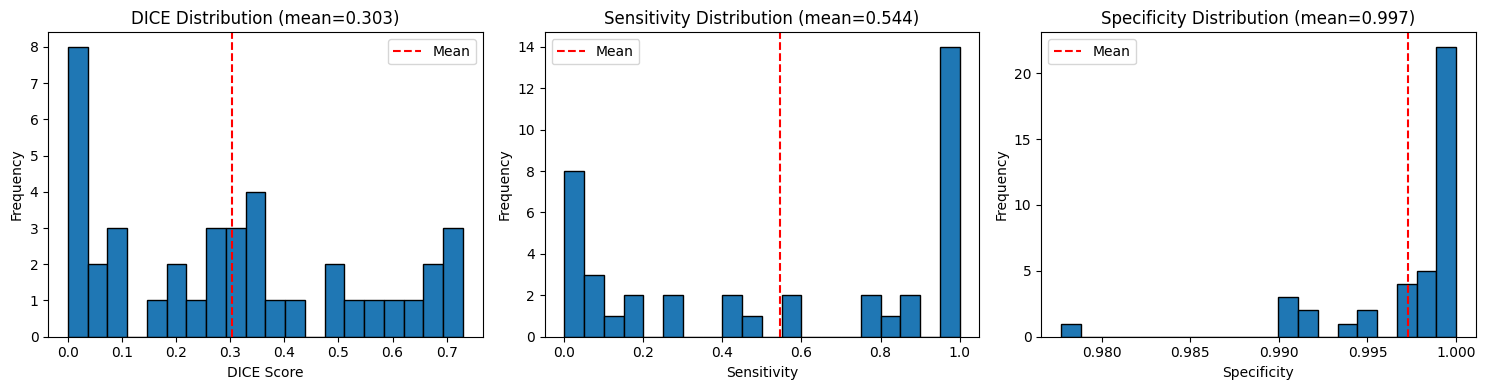


Saved: evaluation_metrics.png


In [14]:
# =========================
# CELL 8: Model Evaluation
# =========================

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

@torch.no_grad()
def evaluate_model(model, test_loader, device, threshold=0.5):
    """Compute DICE, sensitivity, specificity on test set."""
    model.eval()

    all_dice = []
    all_sensitivity = []
    all_specificity = []

    for batch in test_loader:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        # Forward pass
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > threshold).float()

        # Compute metrics per sample
        for i in range(preds.shape[0]):
            pred = preds[i, 0].cpu().numpy().flatten()
            true = masks[i, 0].cpu().numpy().flatten()

            # DICE score
            intersection = (pred * true).sum()
            union = pred.sum() + true.sum()
            dice = (2.0 * intersection + 1e-7) / (union + 1e-7)
            all_dice.append(dice)

            # Confusion matrix elements
            tp = ((pred == 1) & (true == 1)).sum()
            tn = ((pred == 0) & (true == 0)).sum()
            fp = ((pred == 1) & (true == 0)).sum()
            fn = ((pred == 0) & (true == 1)).sum()

            # Sensitivity (recall) and Specificity
            sensitivity = tp / (tp + fn + 1e-7)
            specificity = tn / (tn + fp + 1e-7)

            all_sensitivity.append(sensitivity)
            all_specificity.append(specificity)

    return {
        'dice_mean': np.mean(all_dice),
        'dice_std': np.std(all_dice),
        'sensitivity_mean': np.mean(all_sensitivity),
        'sensitivity_std': np.std(all_sensitivity),
        'specificity_mean': np.mean(all_specificity),
        'specificity_std': np.std(all_specificity),
        'all_dice': all_dice,
        'all_sensitivity': all_sensitivity,
        'all_specificity': all_specificity
    }

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print("Loaded best model for evaluation")

# Create test loader
test_loader = DataLoader(ds_test, batch_size=1, shuffle=False, num_workers=0)

# Evaluate
print("\nEvaluating on test set...")
metrics = evaluate_model(model, test_loader, device)

# Print results
print("\n" + "="*60)
print("TEST SET EVALUATION RESULTS")
print("="*60)
print(f"DICE Score:      {metrics['dice_mean']:.4f} ± {metrics['dice_std']:.4f}")
print(f"Sensitivity:     {metrics['sensitivity_mean']:.4f} ± {metrics['sensitivity_std']:.4f}")
print(f"Specificity:     {metrics['specificity_mean']:.4f} ± {metrics['specificity_std']:.4f}")
print("="*60)

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(metrics['all_dice'], bins=20, edgecolor='black')
axes[0].set_xlabel('DICE Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f"DICE Distribution (mean={metrics['dice_mean']:.3f})")
axes[0].axvline(metrics['dice_mean'], color='r', linestyle='--', label='Mean')
axes[0].legend()

axes[1].hist(metrics['all_sensitivity'], bins=20, edgecolor='black')
axes[1].set_xlabel('Sensitivity')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f"Sensitivity Distribution (mean={metrics['sensitivity_mean']:.3f})")
axes[1].axvline(metrics['sensitivity_mean'], color='r', linestyle='--', label='Mean')
axes[1].legend()

axes[2].hist(metrics['all_specificity'], bins=20, edgecolor='black')
axes[2].set_xlabel('Specificity')
axes[2].set_ylabel('Frequency')
axes[2].set_title(f"Specificity Distribution (mean={metrics['specificity_mean']:.3f})")
axes[2].axvline(metrics['specificity_mean'], color='r', linestyle='--', label='Mean')
axes[2].legend()

plt.tight_layout()
plt.savefig('evaluation_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: evaluation_metrics.png")

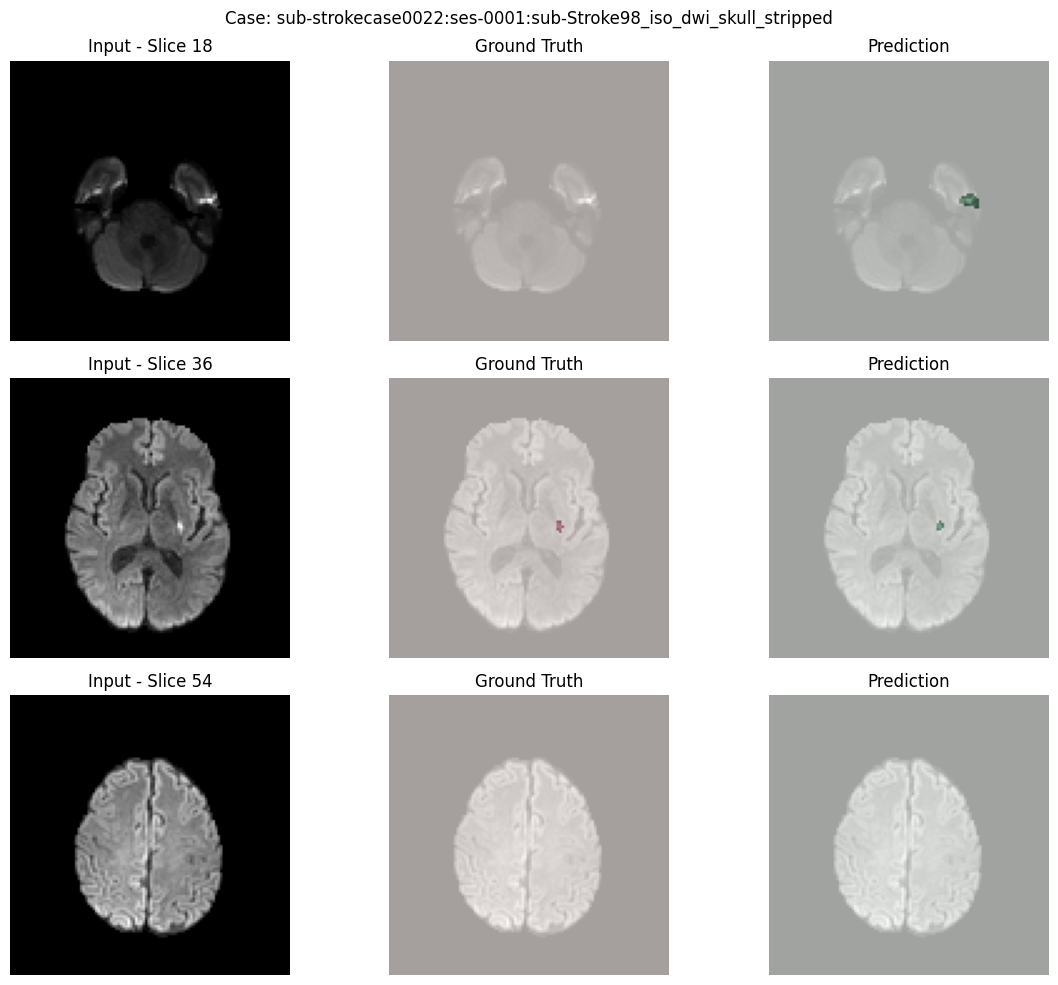


Sample 0:
  True lesion voxels: 163
  Predicted lesion voxels: 365


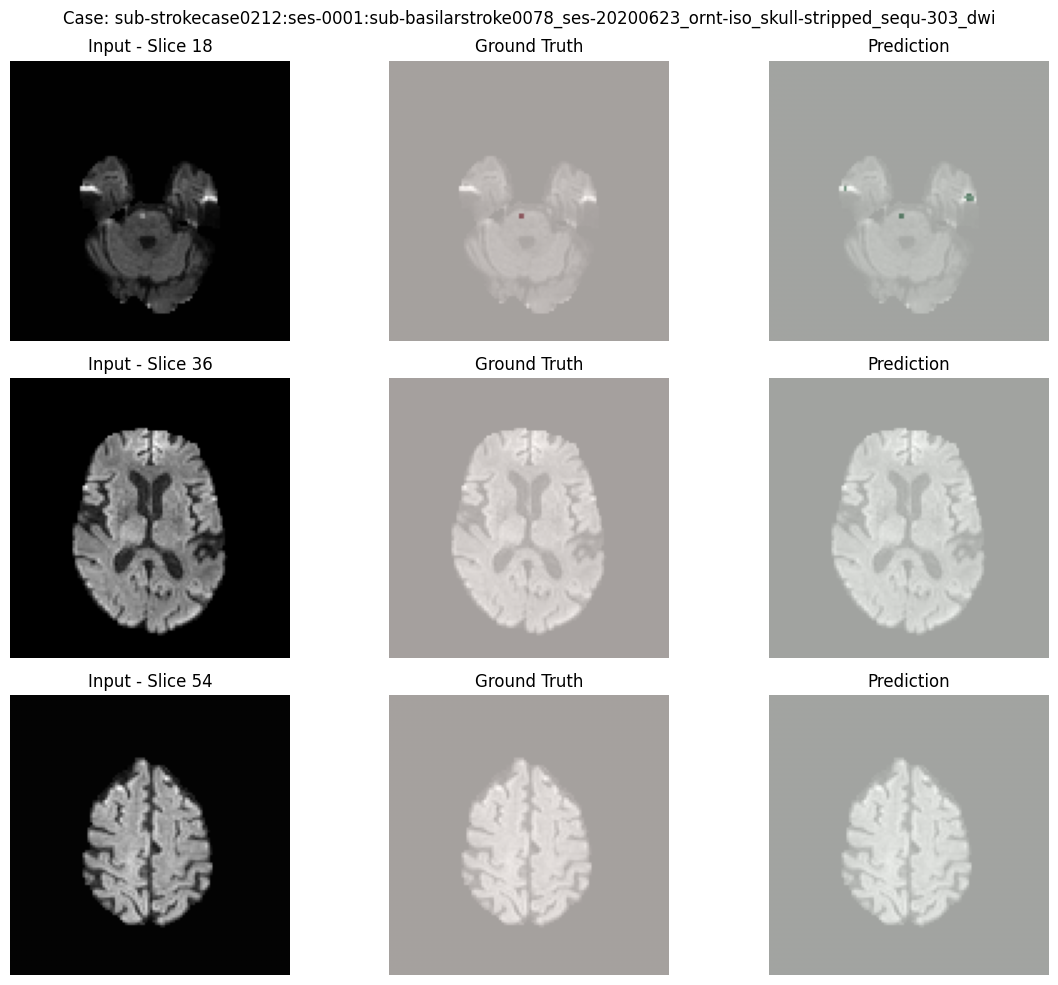


Sample 1:
  True lesion voxels: 138
  Predicted lesion voxels: 34


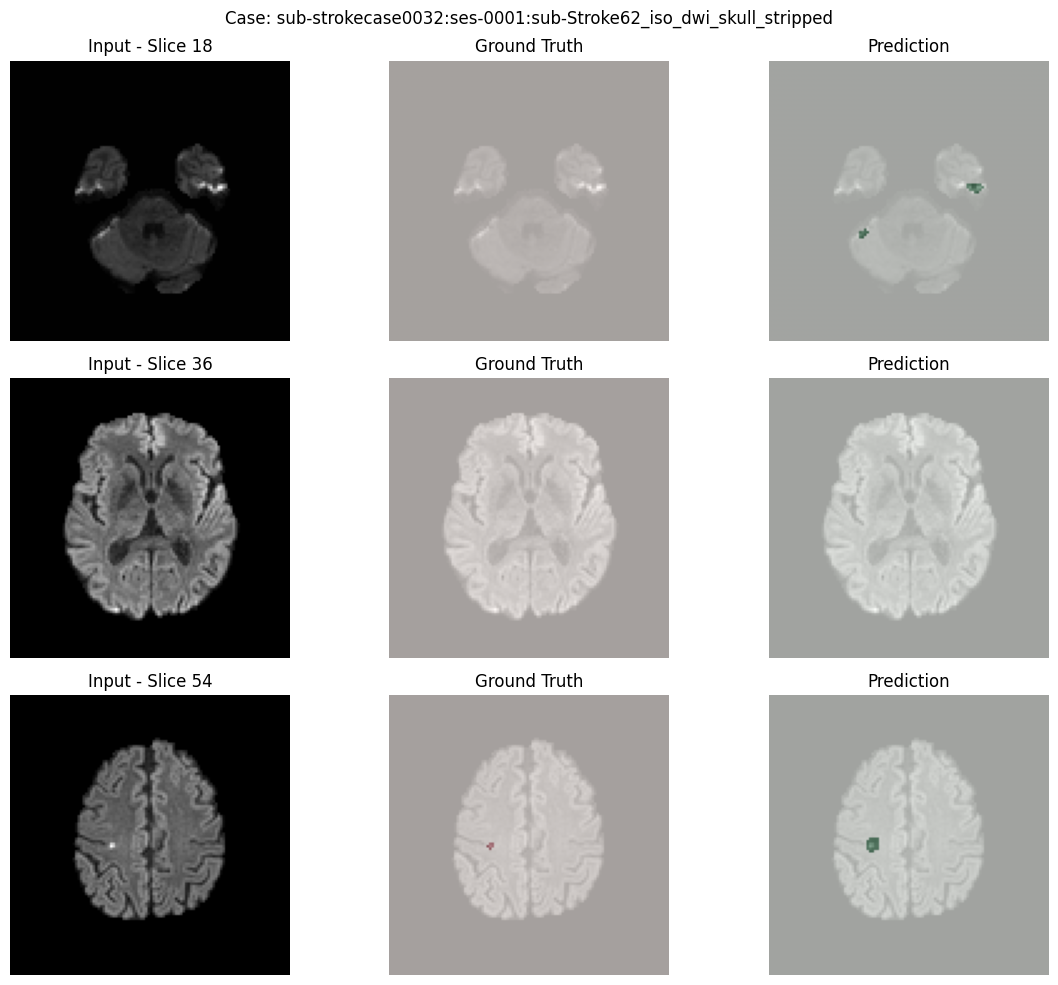


Sample 2:
  True lesion voxels: 67
  Predicted lesion voxels: 521


In [15]:
# =========================
# CELL 9: Visualize Sample Predictions
# =========================

@torch.no_grad()
def visualize_predictions(model, dataset, device, num_samples=3):
    """Visualize predictions vs ground truth."""
    model.eval()

    for idx in range(min(num_samples, len(dataset))):
        sample = dataset[idx]
        image = sample['image'].unsqueeze(0).to(device)
        mask_true = sample['mask'][0].numpy()

        # Predict
        output = model(image)
        mask_pred = (torch.sigmoid(output) > 0.5)[0, 0].cpu().numpy()
        volume = sample['image'][0].numpy()

        # Select middle slices
        Z = volume.shape[-1]
        slices = [Z//4, Z//2, 3*Z//4]

        fig, axes = plt.subplots(len(slices), 3, figsize=(12, 10))
        fig.suptitle(f"Case: {sample['meta']['case_id']}", fontsize=12)

        for i, z in enumerate(slices):
            # Original image
            axes[i, 0].imshow(volume[:, :, z].T, origin="lower", cmap="gray")
            axes[i, 0].set_title(f"Input - Slice {z}")
            axes[i, 0].axis("off")

            # Ground truth
            axes[i, 1].imshow(volume[:, :, z].T, origin="lower", cmap="gray", alpha=0.7)
            axes[i, 1].imshow(mask_true[:, :, z].T, origin="lower", cmap="Reds", alpha=0.5)
            axes[i, 1].set_title("Ground Truth")
            axes[i, 1].axis("off")

            # Prediction
            axes[i, 2].imshow(volume[:, :, z].T, origin="lower", cmap="gray", alpha=0.7)
            axes[i, 2].imshow(mask_pred[:, :, z].T, origin="lower", cmap="Greens", alpha=0.5)
            axes[i, 2].set_title("Prediction")
            axes[i, 2].axis("off")

        plt.tight_layout()
        plt.savefig(f'prediction_sample_{idx}.png', dpi=150, bbox_inches='tight')
        plt.show()

        print(f"\nSample {idx}:")
        print(f"  True lesion voxels: {mask_true.sum():.0f}")
        print(f"  Predicted lesion voxels: {mask_pred.sum():.0f}")

# Visualize 3 test samples
visualize_predictions(model, ds_test, device, num_samples=3)

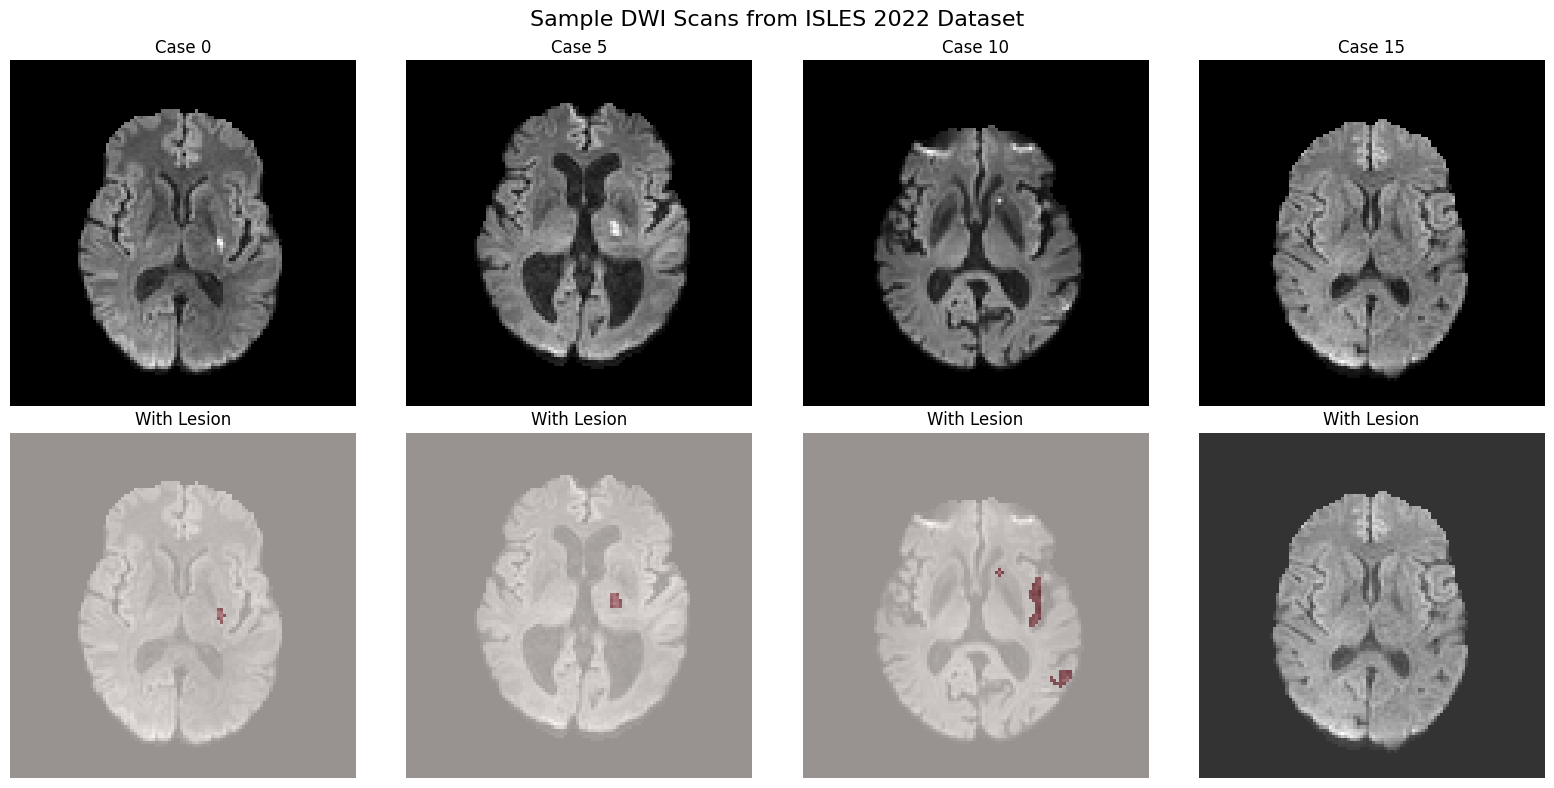

Saved: poster_dwi_samples.png


In [18]:
# =========================
# Extract Sample DWI Slices for Poster
# =========================

import matplotlib.pyplot as plt
import numpy as np

# Select diverse test cases
sample_indices = [0, 5, 10, 15]  # Adjust based on what looks good

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample DWI Scans from ISLES 2022 Dataset', fontsize=16)

for idx, case_idx in enumerate(sample_indices):
    sample = ds_test[case_idx]
    volume = sample['image'][0].numpy()

    # Get middle slice
    z = volume.shape[-1] // 2

    # Top row: full brain
    axes[0, idx].imshow(volume[:, :, z].T, origin="lower", cmap="gray")
    axes[0, idx].set_title(f"Case {case_idx}")
    axes[0, idx].axis("off")

    # Bottom row: with lesion overlay
    mask = sample['mask'][0, :, :, z].numpy()
    axes[1, idx].imshow(volume[:, :, z].T, origin="lower", cmap="gray", alpha=0.8)
    if mask.sum() > 0:
        axes[1, idx].imshow(mask.T, origin="lower", cmap="Reds", alpha=0.5)
    axes[1, idx].set_title("With Lesion")
    axes[1, idx].axis("off")

plt.tight_layout()
plt.savefig('poster_dwi_samples.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Saved: poster_dwi_samples.png")

In [16]:
# =========================
# CELL 10: Explainability - Perturbation Analysis
# =========================

@dataclass
class BaselineConfig:
    kind: str = "local_mean"
    kernel: int = 7
    sigma: float = 1.0

@dataclass
class PerturbationConfig:
    patch_size: Tuple[int, int, int] = (7, 7, 7)
    stride: Tuple[int, int, int] = (4, 4, 4)
    target_class: int = 1
    prob_output: bool = False
    aggregate: str = "max"
    normalize_map: bool = True

def patch_baseline(volume: torch.Tensor, x: slice, y: slice, z: slice, cfg: BaselineConfig):
    patch = volume[..., x, y, z]

    if cfg.kind == "zero":
        return torch.zeros_like(patch)
    if cfg.kind == "gaussian":
        return torch.randn_like(patch) * cfg.sigma

    k = cfg.kernel
    x0, x1 = max(x.start - k, 0), min(x.stop + k, volume.shape[-3])
    y0, y1 = max(y.start - k, 0), min(y.stop + k, volume.shape[-2])
    z0, z1 = max(z.start - k, 0), min(z.stop + k, volume.shape[-1])
    hood = volume[..., x0:x1, y0:y1, z0:z1]
    return torch.ones_like(patch) * hood.mean()

class ResponsibilityComputer:
    def __init__(self, model, device="cpu", base_cfg=None, pert_cfg=None):
        self.model = model.to(device).eval()
        self.device = device
        self.base_cfg = base_cfg or BaselineConfig()
        self.pert_cfg = pert_cfg or PerturbationConfig()

    @torch.no_grad()
    def _forward_prob(self, x):
        out = self.model(x)
        probs = torch.sigmoid(out) if out.shape[1] == 1 else F.softmax(out, dim=1)
        p = probs[:, 0] if probs.shape[1] == 1 else probs[:, self.pert_cfg.target_class]
        if p.ndim == 4:
            p = p.mean(dim=(1, 2, 3))
        return p

    @torch.no_grad()
    def compute(self, volume_np):
        vol = torch.from_numpy(volume_np).float().unsqueeze(0).unsqueeze(0).to(self.device)
        base_prob = self._forward_prob(vol)

        X, Y, Z = volume_np.shape
        psx, psy, psz = self.pert_cfg.patch_size
        stx, sty, stz = self.pert_cfg.stride

        resp = torch.zeros((X, Y, Z), device=self.device)
        count = torch.zeros((X, Y, Z), device=self.device)

        total = ((X - psx) // stx + 1) * ((Y - psy) // sty + 1) * ((Z - psz) // stz + 1)
        print(f"Computing {total} patches...")

        n = 0
        for x0 in range(0, X - psx + 1, stx):
            for y0 in range(0, Y - psy + 1, sty):
                for z0 in range(0, Z - psz + 1, stz):
                    xs, ys, zs = slice(x0, x0 + psx), slice(y0, y0 + psy), slice(z0, z0 + psz)
                    v_cf = vol.clone()
                    v_cf[..., xs, ys, zs] = patch_baseline(vol, xs, ys, zs, self.base_cfg)
                    delta = (base_prob - self._forward_prob(v_cf)).abs().item()

                    if self.pert_cfg.aggregate == "max":
                        resp[xs, ys, zs] = torch.maximum(resp[xs, ys, zs], torch.tensor(delta, device=self.device))
                    else:
                        resp[xs, ys, zs] += delta
                        count[xs, ys, zs] += 1.0

                    n += 1
                    if n % 100 == 0:
                        print(f"  {n}/{total}")

        if self.pert_cfg.aggregate != "max":
            count = torch.clamp(count, min=1.0)
            resp = resp / count

        if self.pert_cfg.normalize_map:
            m = resp.max().clamp(min=1e-6)
            resp = resp / m

        return resp.detach().cpu().numpy().astype(np.float32)

print("✓ Explainability functions loaded")

✓ Explainability functions loaded


Analyzing volume of shape: (112, 112, 73)
Case: sub-strokecase0022:ses-0001:sub-Stroke98_iso_dwi_skull_stripped
Computing 12393 patches...
  100/12393
  200/12393
  300/12393
  400/12393
  500/12393
  600/12393
  700/12393
  800/12393
  900/12393
  1000/12393
  1100/12393
  1200/12393
  1300/12393
  1400/12393
  1500/12393
  1600/12393
  1700/12393
  1800/12393
  1900/12393
  2000/12393
  2100/12393
  2200/12393
  2300/12393
  2400/12393
  2500/12393
  2600/12393
  2700/12393
  2800/12393
  2900/12393
  3000/12393
  3100/12393
  3200/12393
  3300/12393
  3400/12393
  3500/12393
  3600/12393
  3700/12393
  3800/12393
  3900/12393
  4000/12393
  4100/12393
  4200/12393
  4300/12393
  4400/12393
  4500/12393
  4600/12393
  4700/12393
  4800/12393
  4900/12393
  5000/12393
  5100/12393
  5200/12393
  5300/12393
  5400/12393
  5500/12393
  5600/12393
  5700/12393
  5800/12393
  5900/12393
  6000/12393
  6100/12393
  6200/12393
  6300/12393
  6400/12393
  6500/12393
  6600/12393
  6700/12393

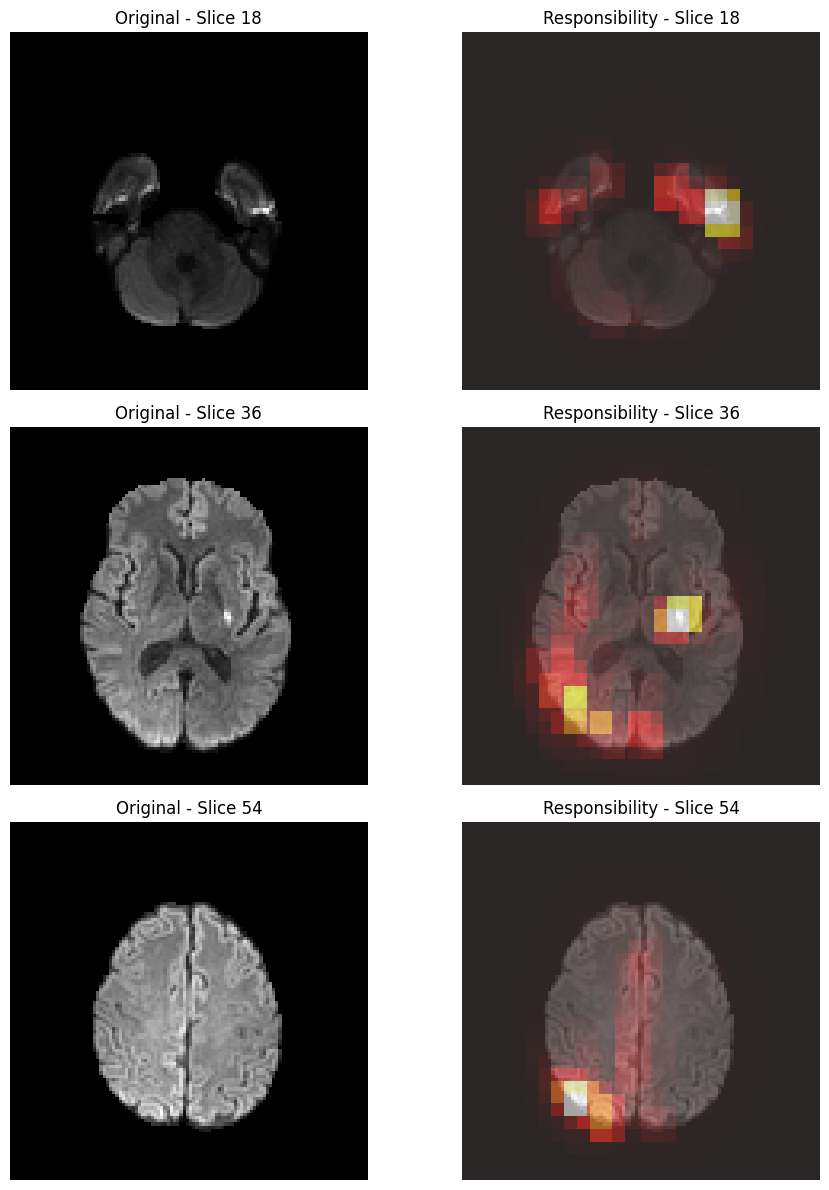


✓ Explainability analysis complete!
Saved: explainability_results.png


In [17]:
# =========================
# CELL 11: Run Explainability Analysis
# =========================

import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Get test sample
test_sample = ds_test[0]
volume = test_sample['image'][0].numpy()  # Remove channel dim

print(f"Analyzing volume of shape: {volume.shape}")
print(f"Case: {test_sample['meta']['case_id']}")

# Compute responsibility
computer = ResponsibilityComputer(model, device=device)
resp_map = computer.compute(volume)

print(f"\nResponsibility map:")
print(f"  Min: {resp_map.min():.4f}")
print(f"  Max: {resp_map.max():.4f}")
print(f"  Mean: {resp_map.mean():.4f}")

# Visualize
Z = volume.shape[-1]
slices_to_show = [Z//4, Z//2, 3*Z//4]

fig, axes = plt.subplots(len(slices_to_show), 2, figsize=(10, 12))

for i, z in enumerate(slices_to_show):
    # Original
    axes[i, 0].imshow(volume[:, :, z].T, origin="lower", cmap="gray")
    axes[i, 0].set_title(f"Original - Slice {z}")
    axes[i, 0].axis("off")

    # Responsibility overlay
    axes[i, 1].imshow(volume[:, :, z].T, origin="lower", cmap="gray", alpha=0.7)
    axes[i, 1].imshow(resp_map[:, :, z].T, origin="lower", cmap="hot", alpha=0.5)
    axes[i, 1].set_title(f"Responsibility - Slice {z}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.savefig("explainability_results.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Explainability analysis complete!")
print("Saved: explainability_results.png")